In [1]:
%matplotlib inline

import sys
import time
import math
import outliers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn import svm

import multiprocessing
import tempfile
import os
from joblib import Parallel, delayed
from joblib.pool import has_shareable_memory
cpuN = multiprocessing.cpu_count()

import warnings
warnings.filterwarnings('ignore')

prescription = pd.read_csv('data/prescriptions2017_clean.csv.gz', compression='gzip')

In [2]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from sklearn.svm import OneClassSVM

def computeCLF(X,Y,epsilon,scores,clf_name):
    
    classifiers = outliers.getClassifiers(epsilon)
    
    try:
        clf = classifiers[clf_name]
        if clf_name == 'LOF':
            y_pred = clf.fit_predict(X)
        else:
            clf.fit(X)
            y_pred = clf.predict(X)

        y_pred[y_pred == 1] = 0
        y_pred[y_pred == -1] = 1
        f = f1_score(y_pred, Y)
        scores[int(epsilon*100)] = f
    except:
        scores[int(epsilon*100)] = 0

In [7]:
folder = tempfile.mkdtemp()
score_name = os.path.join(folder, 'score')

classifiers = outliers.getRanges()

mean_ep = pd.DataFrame()
mean_f = pd.DataFrame()

#med = 'ANLODIPINO 10 mg CP' #X
#med = 'DICLOFENACO 50 mg CP' X
#med = 'AMPICILINA + SULBACTAM 2 g + 1 g SOL INJ' X
med = 'VARFARINA 5 mg CP' # V
#med = 'HIOSCINA (BUTILBROMETO DE ESCOPOLAMINA) 20 mg/ml SOL INJ' # V
#med = 'TRAMADOL 50mg/ml 1ml SOL INJ'
#med = 'VITAMINAS DO COMPLEXO B CP' X

X, Y = outliers.getPrescriptions(prescription, med)
anomalies = len(Y[Y==1])
total = len(X)

print(med + ', Size: ', total, ' Overdose: ', anomalies)

for i, (clf_name, ep_range) in enumerate(classifiers.items()):

    print(clf_name)
    
    index_list = np.append([], [])
    skf = StratifiedKFold(n_splits=anomalies)
    div = 1
    for train_index, test_index in skf.split(X, Y):
        
        scores_df = pd.DataFrame()
        
        index_list = np.append(index_list.astype(int), test_index.astype(int))
        size = len(index_list)
        
        X_train = X[index_list]
        Y_train = Y[index_list]
        overdose_size = len(Y_train[Y_train==1])
        
        if (size // 100) < div:
            continue
            
        size_idx = div * 100
        div = 1 + (size // 100)
        
        sys.stdout.write(str(overdose_size) + '/' + str(size) +', ')
        
        scores = np.memmap(score_name, dtype=float, shape=(150), mode='w+')
        
        Parallel(n_jobs=cpuN)(delayed(computeCLF)(X_train, Y_train,epsilon,scores,clf_name)
                   for epsilon in ep_range)
        
        for ep in ep_range:
            idx = int(ep*100)
            scores_df.loc[clf_name,ep] = scores[idx]
        
        ep_max = scores_df.loc[clf_name].idxmax()
        mean_ep.loc[clf_name,size_idx] = float(ep_max)
        mean_f.loc[clf_name,size_idx] = scores_df.loc[clf_name].max()
        
        sys.stdout.write('('  + str(ep_max) + ',' + str(scores_df.loc[clf_name].max()) +') ')
        
        if size > 5000:
            break

    print('')

print('Done')
mean_ep

VARFARINA 5 mg CP, Size:  6419  Overdose:  127
Cov
2/102, (0.01,1.0) 4/204, (0.01,0.0) 6/306, (0.01,0.0) 8/408, (0.01,0.0) 10/510, (0.01,0.0) 12/612, (0.01,0.0) 14/714, (0.01,0.0) 16/816, (0.01,0.0) 18/918, (0.01,0.0) 20/1020, (0.01,0.0) 22/1122, (0.01,0.0) 24/1224, (0.01,0.0) 26/1326, (0.01,0.0) 28/1428, (0.01,0.0) 30/1530, (0.02,1.0) 32/1632, (0.05,1.0) 34/1734, (0.02,1.0) 36/1836, (0.14,1.0) 38/1938, (0.05,1.0) 40/2040, (0.11,1.0) 42/2142, (0.02,1.0) 44/2244, (0.05,1.0) 46/2346, (0.05,1.0) 48/2448, (0.11,1.0) 50/2550, (0.02,1.0) 51/2601, (0.02,1.0) 53/2703, (0.29,0.224101479915) 55/2805, (0.14,1.0) 57/2907, (0.02,1.0) 59/3009, (0.02,1.0) 61/3111, (0.02,1.0) 63/3213, (0.02,1.0) 65/3315, (0.02,1.0) 67/3417, (0.05,1.0) 69/3519, (0.02,1.0) 71/3619, (0.02,1.0) 73/3719, (0.05,1.0) 75/3819, (0.05,1.0) 77/3919, (0.02,1.0) 79/4019, (0.05,1.0) 81/4119, (0.01,0.0) 83/4219, (0.02,1.0) 85/4319, (0.4,0.10101010101) 87/4419, (0.01,0.0) 89/4519, (0.02,1.0) 91/4619, (0.01,0.0) 93/4719, (0.01,0.0) 95

,100,200,300,400,500,600,700,800,900,1000,...,4100,4200,4300,4400,4500,4600,4700,4800,4900,5000
Cov,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.02,0.40,0.01,0.02,0.01,0.01,0.02,0.05,0.02
DDC-J,0.08,0.10,0.10,0.10,0.10,0.10,0.12,0.12,0.12,0.12,...,0.18,0.17,0.17,0.17,0.18,0.17,0.17,0.17,0.17,0.17
IsoF,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.01,0.01,0.01
DDC-C,0.90,0.91,0.91,0.91,0.91,0.91,0.01,0.01,0.01,0.01,...,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76


In [8]:
#methods = ['SVM','LOF','IsoF','Cov','Gau','DDC-C','DDC-J','DDC-H','DDC-M','DDC']
methods = ['IsoF','Cov','DDC-J','DDC-C']
colors = ['b', 'g', 'r', 'm', 'k', 'y', 'c', 'orange', 'brown', 'pink']
markers = ['D', 's', 'o', 'v', '1', '2', '3', '4', '8', '+']

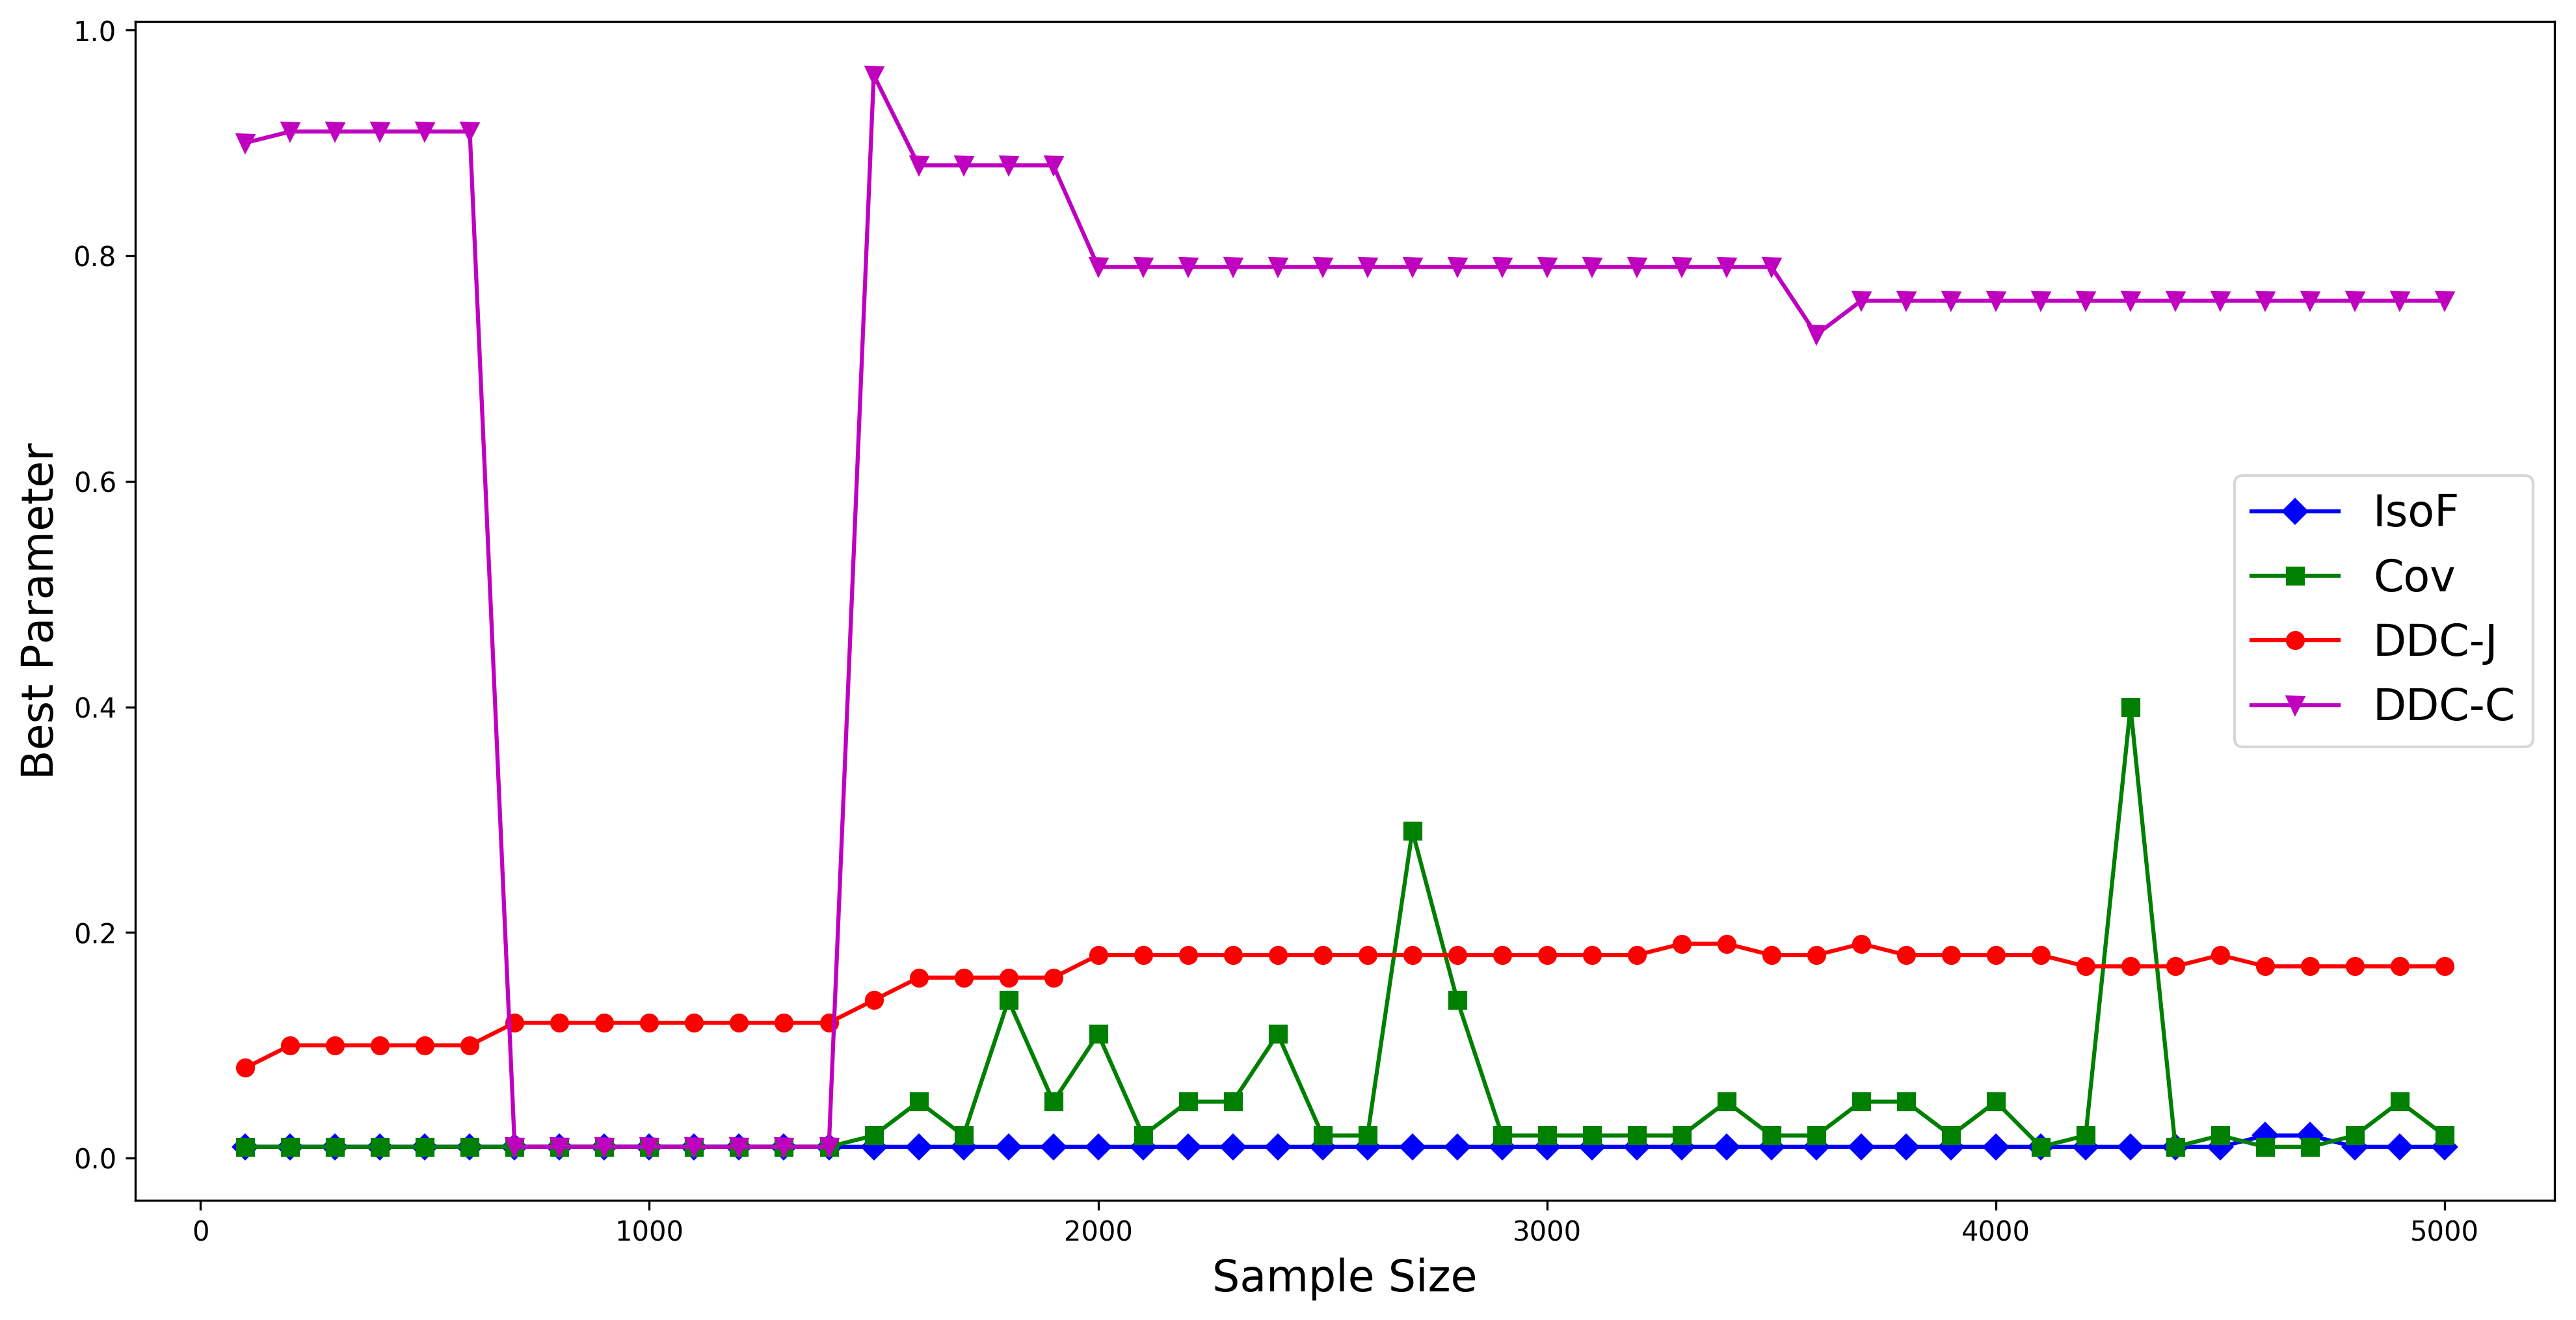

In [9]:
plt.figure(figsize=(16, 8), dpi= 300)
i = 0
for m in methods:
    plt.plot(np.asarray(mean_ep.columns),np.asarray(mean_ep.loc[m].values), c=colors[i],label=m, marker=markers[i])
    i += 1
    
plt.legend(fontsize=16)
plt.xlabel('Sample Size', fontsize=16)
plt.ylabel('Best Parameter', fontsize=16)
#plt.ylim(0,22)
#plt.xlim(0,28000)
plt.show()

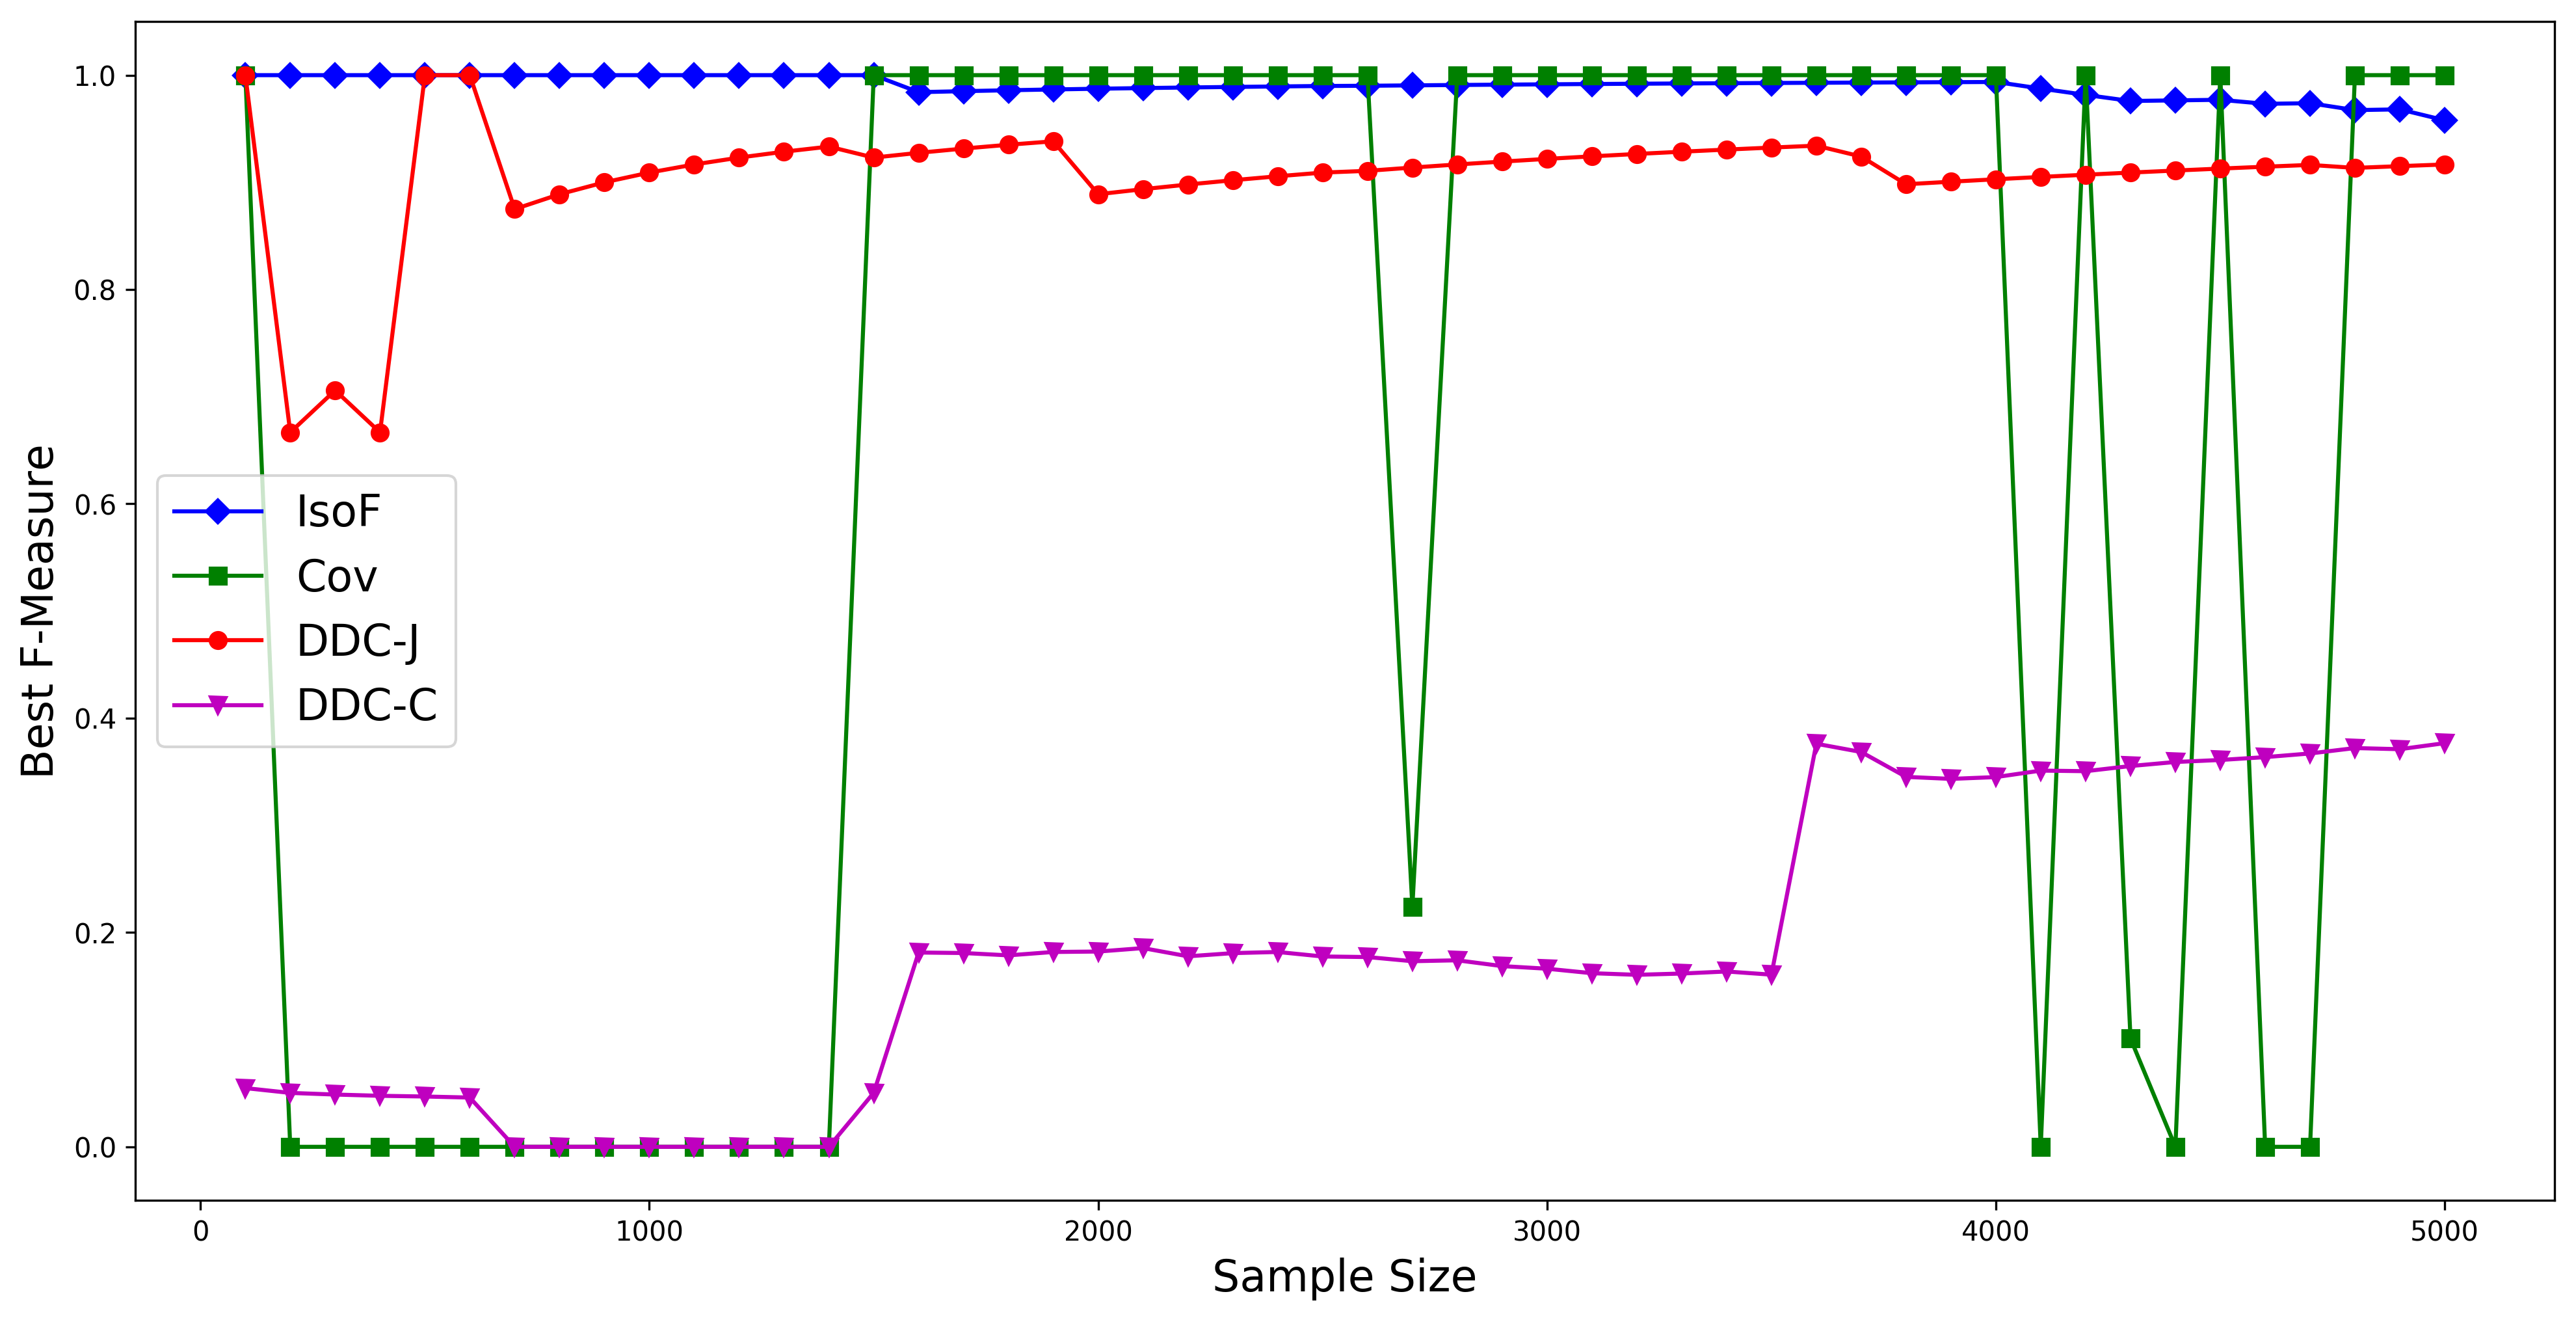

In [10]:
plt.figure(figsize=(16, 8), dpi= 300)
i = 0
for m in methods:
    plt.plot(np.asarray(mean_f.columns),np.asarray(mean_f.loc[m].values), c=colors[i],label=m, marker=markers[i])
    i += 1
    
plt.legend(fontsize=16)
plt.xlabel('Sample Size', fontsize=16)
plt.ylabel('Best F-Measure', fontsize=16)
#plt.ylim(0,22)
#plt.xlim(0,28000)
plt.show()